# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Требуется построить модель со значением *F1*-меры не меньше 0.59.


## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import dump
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
display(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data = data.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

In [5]:
print(data.dtypes)

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [6]:
data = data.dropna()

In [7]:
data_train, data_common = train_test_split(data,  test_size = 0.4, random_state = 12345)
data_valid, data_test = train_test_split(data_common,  test_size = 0.5, random_state = 12345)

Разбили данные на три выборки: обучающую, валидационную и тестовую, соотношение 3:1:1 (60% : 20% : 20%)

In [8]:
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited'] 
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

features - признаки
target - целевой признак

С помощью техники ohe преобразуем категориальные признаки в численные:

In [9]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

Поскольку в данных присутствуют количественные признаки с разными разбросами значений, нужно привести признаки к одному масштабу:

In [10]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверяем размеры выборок:

In [11]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(5454, 11)
(5454,)
(1818, 11)
(1818,)
(1819, 11)
(1819,)


## Исследование задачи

Дерево решений без учета дисбаланса классов:

In [12]:
best_result = 0
best_model_decision_tree = None
for depth in range(1, 6):
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model_decision_tree.fit(features_train, target_train)
    predictions_valid =  model_decision_tree.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_model_decision_tree = model_decision_tree
        best_result = result 

print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Accuracy наилучшей модели на валидационной выборке: 0.8575357535753575


Создали константную модель:

In [13]:
target_pred_constant = pd.Series([0]*len(target_valid))
print(accuracy_score(target_valid, target_pred_constant))

0.7926292629262927


Accuracy решающего дерева и константной модели почти одинаковы.
В задаче наблюдается дисбаланс классов. Для оценки качества модели accuracy не подходит.

In [14]:
best_result = 0
best_model_decision_tree = None
for depth in range(1, 6):
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model_decision_tree.fit(features_train, target_train)
    predicted_valid =  model_decision_tree.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model_decision_tree = model_decision_tree
        best_result = result 
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.5414551607445008


Случайный лес без учета дисбаланса классов:

In [15]:
best_model_forest = None
best_result = 0
for est in range(1, 11):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train) 
        predicted_valid =  model_forest.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest = model_forest
            best_result = result
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.569364161849711


Логистическая регрессия без учета дисбаланса классов:

In [16]:
model_regression = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_regression.fit(features_train, target_train)
predicted_valid =  model_regression.predict(features_valid) 
dump(model_regression, 'model_9_1.joblib')
print("F1 мера наилучшей модели на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1 мера наилучшей модели на валидационной выборке: 0.3033932135728543


F1-мера

Дерево решений без учета дисбаланса классов: 0.5414551607445008

Случайный лес без учета дисбаланса классов: 0.569364161849711

Логистическая регрессия без учета дисбаланса классов: 0.303393213572854

Дисбаланс классов плохо сказывается на обучении модели. 

## Борьба с дисбалансом

0    0.793546
1    0.206454
Name: Exited, dtype: float64


<AxesSubplot:>

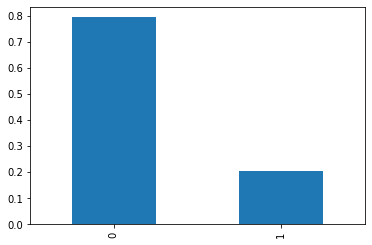

In [17]:
class_frequency = data_train['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar')

Для борьбы с дисбалансом классов используем class_weight, техники upsampling и downsampling.

# upsample

In [18]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

Дерево решений:

In [19]:
best_result = 0
best_model_decision_tree_upsample = None
for depth in range(1, 6):
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model_decision_tree.fit(features_upsampled, target_upsampled)
    predicted_valid =  model_decision_tree.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model_decision_tree_upsample = model_decision_tree
        best_result = result 
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.5929526123936817


In [20]:
probabilities_valid = best_model_decision_tree_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.8400158672598789


Случайный лес:

In [21]:
best_model_forest_upsample = None
best_result = 0
for est in range(1, 11):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled) 
        predicted_valid =  model_forest.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest_upsample = model_forest
            best_result = result
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.6349999999999999


In [22]:
probabilities_valid = best_model_forest_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.8628779748811336


Логистическая регрессия:

In [23]:
model_regression_upsample = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000) 
model_regression_upsample.fit(features_upsampled, target_upsampled)
predicted_valid = model_regression_upsample.predict(features_valid) 
print("F1 мера наилучшей модели на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1 мера наилучшей модели на валидационной выборке: 0.5050055617352613


In [24]:
probabilities_valid = model_regression_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.7773558371084035


F1-мера

Дерево решений upsampling: 0.5902439024390244

Случайный лес upsampling: 0.5371775417298937

Логистическая регрессия upsampling: 0.47016706443914086

AUC-ROC

Дерево решений upsampling: 0.8354075511222129

Случайный лес upsampling: 0.7977771110174374

Логистическая регрессия upsampling: 0.7371152143460645

# downsample

In [25]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.66)

Дерево решений:

In [26]:
best_result = 0
best_model_decision_tree_downsample = None
for depth in range(1, 6):
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model_decision_tree.fit(features_downsampled, target_downsampled)
    predicted_valid =  model_decision_tree.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model_decision_tree_downsample = model_decision_tree
        best_result = result 
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.5926892950391645


In [27]:
probabilities_valid = best_model_decision_tree_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.8425432161941769


Случайный лес:

In [28]:
best_model_forest = None
best_result = 0
for est in range(1, 11):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled) 
        predicted_valid =  model_forest.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest_downsample = model_forest
            best_result = result
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.6115444617784712


In [29]:
probabilities_valid = best_model_forest_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.8624555228924801


Логистическая регрессия:

In [30]:
model_regression_downsample = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000) 
model_regression_downsample.fit(features_downsampled, target_downsampled)
predicted_valid = model_regression_downsample.predict(features_valid)
print("F1 мера наилучшей модели на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1 мера наилучшей модели на валидационной выборке: 0.4150326797385621


In [31]:
probabilities_valid = model_regression_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.7746683429757922


F1-мера

Дерево решений downsampling: 0.59375

Случайный лес downsampling: 0.21559633027522934

Логистическая регрессия downsampling: 0.42022116903633494

AUC-ROC

Дерево решений downsampling: 0.8427475393782318

Случайный лес downsampling: 0.7512079917976205

Логистическая регрессия downsampling: 0.7535531065407347

# class_weight

Дерево решений:

In [32]:
best_result = 0
best_model_decision_tree_class_weight = None
for depth in range(1, 6):
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth, class_weight = 'balanced')
    model_decision_tree.fit(features_train, target_train)
    predicted_valid =  model_decision_tree.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model_decision_tree_class_weight = model_decision_tree
        best_result = result 
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.5735449735449736


In [33]:
probabilities_valid = best_model_decision_tree_class_weight.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.8396523192522141


Случайный лес:

In [34]:
best_model_forest_class_weight = None
best_result = 0
for est in range(1, 11):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight = 'balanced')
        model_forest.fit(features_train, target_train) 
        predicted_valid =  model_forest.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest_class_weight = model_forest
            best_result = result
print("F1 мера наилучшей модели на валидационной выборке:", best_result)

F1 мера наилучшей модели на валидационной выборке: 0.6497584541062802


In [35]:
probabilities_valid = best_model_forest_class_weight.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.8690573706367336


Логистическая регрессия:

In [36]:
model_regression_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
model_regression_balanced.fit(features_train, target_train)
predicted_valid = model_regression_balanced.predict(features_valid)
print("F1 мера наилучшей модели на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1 мера наилучшей модели на валидационной выборке: 0.5092592592592593


In [37]:
probabilities_valid = model_regression_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC наилучшей модели на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC наилучшей модели на валидационной выборке: 0.7777681649753247


F1-мера

Дерево решений class_weight: 0.5711252653927813

Случайный лес class_weight: 0.5387840670859538

Логистическая регрессия class_weight: 0.4818276220145379

AUC-ROC

Дерево решений class_weight: 0.8356127946809706

Случайный лес class_weight: 0.7902024272121667

Логистическая регрессия class_weight: 0.7462563758957547

С помощью техники upsampling получили самое высокое значение метрики f1 на дереве решений: 0.5929526123936817.

С помощью class_weight получили самое высокое значение метрики f1 на логистической регрессии: 0.5092592592592593

С помощью class_weight получили самое высокое значение метрики f1 на случайном лесе: 0.6497584541062802


С помощью техники downsampling получили самое высокое значение метрики AUC-ROC на дереве решений: 0.8425432161941769.

С помощью техники downsampling получили самое высокое значение метрики AUC-ROC на логистической регрессии: 0.7777681649753247.

С помощью техники class_weight получили самое высокое значение метрики AUC-ROC на случайном лесе: 0.8690573706367336.

## Тестирование модели

In [38]:
predicted_test = best_model_forest_class_weight.predict(features_test)
print("Тестовая выборка:", f1_score(target_test, predicted_test))

Тестовая выборка: 0.5936675461741425
